In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
sns.set_theme()
# Load data (city)
df = pd.read_csv('../data/GlobalLandTemperaturesByCity.csv')
df['dt'] = pd.DatetimeIndex(df['dt'])
df['Year'] = pd.DatetimeIndex(df['dt']).year
df = df[df['Year'] != 1743]
df = df[df['Year'] != 2013]

# For each country average all AverageTemperature values and add iso_alpha to countries
df_avg = pd.DataFrame({'AverageTemperature': df.groupby('Country')['AverageTemperature'].mean(), 'Country': df.groupby('Country')['Country'].first()})
df_avg = df_avg.reset_index(drop=True)
#print('Average country temperature df: ', df_avg)

df_avg_city = pd.DataFrame({'AverageTemperature': df.groupby('City')['AverageTemperature'].mean(), 'City': df.groupby('City')['City'].first()})
df_avg_city = df_avg_city.reset_index(drop=True)
#print('\n \n Average city temperature df: ', df_avg_city)

# For each Country for each Year average all AverageTemperature values
D1 = df.groupby(['Year', 'Country'])['AverageTemperature'].mean().reset_index()
meantemp = D1.groupby('Year')['AverageTemperature'].mean().reset_index() # Rough - er ren average.
meantemp1900 = meantemp[156:] # 1900-2012

# Normalize temperature relative to median
mediantemp = D1.groupby('Country')['AverageTemperature'].median()
df.groupby(['Year','Country'])['AverageTemperature'].mean().reset_index()['AverageTemperature']
#temp.columns = ['Year', 'Country', 'mean','median']
#D1['NormalizedTemperature'] = temp['mean'] - temp['median']
df

import copy
D2 = copy.deepcopy(D1)
normies = np.array([])
for country in D2['Country'].unique():
    norm = np.array(D2.groupby('Country')['AverageTemperature'].get_group(country) - D2.groupby('Country')['AverageTemperature'].get_group(country).median())
    normies = np.append(normies, norm)
D2['NormalizedTemperature'] = normies


FileNotFoundError: [Errno 2] No such file or directory: '../data/GlobalLandTemperaturesByCity.csv'

In [27]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()

In [13]:
# fit an ARIMA model and plot residual error

# fit model
modeltype = ARIMA(meantemp1900.AverageTemperature, order=(2,1,2))
model = modeltype.fit()
# summary of fit model
print(model.summary())
# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()

# # density plot of residuals
residuals.plot(kind='kde')
# # summary stats of residuals
print(residuals.describe())

NameError: name 'meantemp1900' is not defined

In [14]:
plt.plot(meantemp1900.AverageTemperature[2:])
plt.plot(model.fittedvalues[2:], color='red')


NameError: name 'meantemp1900' is not defined

### Using TSA to predict future CO2 emissions

In [15]:
df3 = pd.read_csv('../data/annual-co-emissions-by-region.csv')
df3 = df3.rename(columns={'Annual CO2 emissions (zero filled)': "Annual CO2 emissions"})
df3 = df3.loc[df3['Entity'] == 'World']
df3 = df3.sort_values('Year')
px.line(df3, x = 'Year', y = 'Annual CO2 emissions')

#### First order difference to account for increasing trend

In [16]:
diff1 = np.diff(np.log(df3['Annual CO2 emissions'])) 
df3['Log transformed first order differenced CO2 emissions'] = np.pad(diff1, (0, 1), 'constant')
df3['Log transformed CO2 emissions'] = np.log(df3['Annual CO2 emissions'])
px.line(df3, x = 'Year', y = 'Log transformed first order differenced CO2 emissions')

#### Checking for stationarity

In [17]:
# Dickey-Fuller test of stationarity
ad_fuller_result = adfuller(df3['Log transformed first order differenced CO2 emissions'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -19.140349334203112
p-value: 0.0


#### Inspecting the ACF and PACF

C:\Users\kathr\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



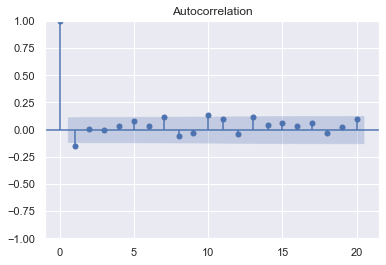

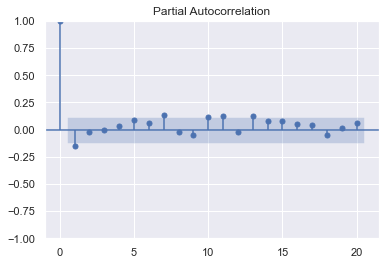

In [20]:
acf = plot_acf(df3['Log transformed first order differenced CO2 emissions'], lags = 20)
pacf = plot_pacf(df3['Log transformed first order differenced CO2 emissions'], lags = 20)
plt.show(acf)
plt.show(pacf)

In [25]:
# Finding optimal ARIMA order
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = ARIMA(df3['Log transformed first order differenced CO2 emissions'], order = order).fit()
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    print(result_df)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [28]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df3['Log transformed CO2 emissions'])

  0%|          | 0/64 [00:00<?, ?it/s]

            0           1
0   (0, 1, 0) -609.422760
1   (0, 1, 1) -830.101870
2   (0, 1, 2) -840.546416
3   (0, 1, 3) -840.014817
4   (0, 1, 4) -839.237948
..        ...         ...
59  (7, 1, 3) -835.344093
60  (7, 1, 4) -831.292570
61  (7, 1, 5) -832.912258
62  (7, 1, 6) -830.076909
63  (7, 1, 7) -831.864412

[64 rows x 2 columns]


In [29]:
print(result_df[result_df.AIC == result_df.AIC.min()])

   (p, d, q)         AIC
0  (1, 1, 2) -840.987831


In [30]:
# 1,1,2 ARIMA Model
model = ARIMA(df3['Log transformed CO2 emissions'], order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())
model_fit

                                     SARIMAX Results                                     
Dep. Variable:     Log transformed CO2 emissions   No. Observations:                  271
Model:                            ARIMA(1, 1, 2)   Log Likelihood                 424.025
Date:                           Wed, 04 May 2022   AIC                           -840.049
Time:                                   15:32:23   BIC                           -825.656
Sample:                                        0   HQIC                          -834.269
                                           - 271                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9960      0.005    206.102      0.000       0.986       1.005
ma.L1         -1.1963      0.046    -26.230

In [31]:
y = 2020
for i in range(10):
    y = y + 1
    df3 = df3.append({'Entity': 'World', 'Code': 'OWID_WRL','Year': y, 'Annual CO2 emissions': float("NAN"), 'Log transformed first order differenced CO2 emissions': float("NAN"),'Log transformed CO2 emissions': float("NAN")}, ignore_index=True)

In [32]:
preds = model_fit.get_prediction(0,281)  # 95% conf
preds_ci = preds.conf_int()
preds_ci

,lower Log transformed CO2 emissions,upper Log transformed CO2 emissions
0,-1959.963988,1959.963988
1,15.939692,16.162194
2,15.939723,16.162164
3,15.942674,16.160011
4,15.945253,16.157581
...,...,...
277,24.140631,24.621971
278,24.131697,24.656296
279,24.122779,24.690502
280,24.113811,24.724657


In [33]:
preds_mu = preds.predicted_mean
df3['Predictions'] = preds_mu

In [34]:
# Plot 
fig = px.line(df3, x='Year', y='Annual CO2 emissions')

# Only thing I figured is - I could do this 
fig.add_scatter(x=df3['Year'], y=np.exp(df3['Predictions']), mode='lines')

# Show plot 
fig.show()